In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML


from lane_detection import *
from image_transformation import *
from utils import *

images = glob.glob("test_images/*")

# Undistort image
pts = calibrate_camera()

%matplotlib inline

# Analysis

## Distortion correction &  Thresholding  & Region of Interest

In [ ]:
img  = cv2.imread(images[0])
dst = undistort_image(img, pts)

plt.figure(figsize=(200,100))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(dst)

In [ ]:
# explanatory analysis to show all the threshold techniques
masked = lane_masking_all(dst)
show_masks(masked)

In [ ]:
FONT_SIZE = 20
masked_img = lane_masking(dst)

plt.figure(figsize=(30,15))
plt.subplot(2,1,1)
plt.imshow(masked_img,cmap='gray')
plt.title('Thresholded Image',fontsize=FONT_SIZE)
_img = region_of_interest(masked_img)
plt.subplot(2,1,2)
plt.imshow(_img,cmap='gray')
plt.title('Region of Interest',fontsize=FONT_SIZE)

## Perspective Transform

In [ ]:
offset = 25
left,right = fit_lanes(_img)
src = retrieve_src_points(left, right, masked_img.shape[0])
dst = np.float32([src[0], (src[0][0], offset), src[2], (src[2][0], offset)])

In [ ]:
# Show the transformation points

plt.imshow(masked_img,cmap='gray')
plt.scatter(src[0][0], src[0][1],c='r')
plt.scatter(src[1][0], src[1][1],c='r')
plt.scatter(src[2][0], src[2][1],c='r')
plt.scatter(src[3][0], src[3][1],c='r')

plt.scatter(dst[0][0], dst[0][1],c='b')
plt.scatter(dst[1][0], dst[1][1],c='b')
plt.scatter(dst[2][0], dst[2][1],c='b')
plt.scatter(dst[3][0], dst[3][1],c='b')

In [ ]:
class PerspectiveTransformer:
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)

    def transform(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    def inverse_transform(self, img):
        return cv2.warpPerspective(img, self.M_inv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

In [ ]:
transformer = PerspectiveTransformer(src, dst)
transformed_image = transformer.transform(_img)
plt.imshow(transformed_image,cmap='gray')

## Lane Curvature 

In [ ]:
# # Fit polynomial to compute the curvature
left_fit, right_fit = fit_poly_lanes(transformed_image)

In [ ]:
# Visualize the fit
ploty = np.linspace(0, transformed_image.shape[0]-1, transformed_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.imshow(transformed_image,cmap='gray')
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='blue')

In [ ]:
left_curverad, right_curverad = measure_curvature(left_fit, right_fit, transformed_image.shape[0])

In [ ]:
def retrieve_src_points(left, right, shape):
    y_cutoff = 7 * shape // 10
    left_cutoff_ix = (left[:,1] > y_cutoff).nonzero()[0].max()
    right_cutoff_ix = (right[:,1] > y_cutoff).nonzero()[0].min()
    p1, p2 = left[left_cutoff_ix,], right[right_cutoff_ix,]

    # Retreieve the trapezoid for perspective transformation
    # We can use the points for all images
    l = {}
    l1, l2 = np.array([int(left[:,0].min()), int(left[:,1].max())]), p1

    r = {}
    r1, r2 = np.array([int(right[:,0].max()), int(right[:,1].max())]), p2

    return np.float32([l1, l2, r1, r2])

# Pipeline 

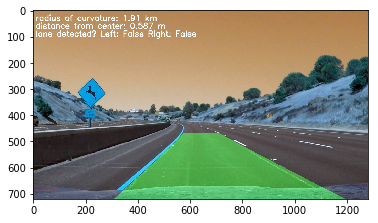

In [17]:
# First Video
img = cv2.imread(images[-5])
left, right = Line(), Line()
transformer = setup_transformation_pipeline()
fun = lambda x: process(x, transformer, left, right)
_img = fun(img)
plt.imshow(_img)

appending additional binary masking


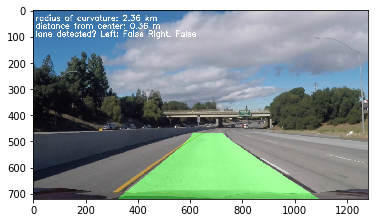

In [16]:
# Challange Video
challenge_output = 'annotated_challange_video.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
img = clip2.get_frame(288)
left, right = Line(), Line()
transformer = setup_transformation_pipeline()
fun = lambda x: process(x, transformer, left, right)
_img = fun(img)
plt.imshow(_img)

# Testing

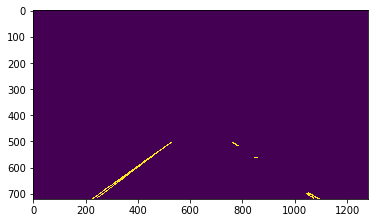

In [3]:
transformer = setup_transformation_pipeline()
left, right = Line(), Line()
fun = lambda x: process(x, transformer, left, right)

def wrap(image):
    try:
        return fun(image)
    except:
        return image

[MoviePy] >>>> Building video annotated_project_video.mp4
[MoviePy] Writing video annotated_project_video.mp4


 45%|████▌     | 568/1261 [15:08<17:22,  1.50s/it]

appending additional binary masking


 45%|████▌     | 570/1261 [15:11<17:31,  1.52s/it]

appending additional binary masking


 45%|████▌     | 571/1261 [15:13<17:35,  1.53s/it]

appending additional binary masking


 45%|████▌     | 572/1261 [15:14<17:52,  1.56s/it]

appending additional binary masking


 47%|████▋     | 598/1261 [15:54<17:13,  1.56s/it]

appending additional binary masking


 48%|████▊     | 604/1261 [16:03<16:36,  1.52s/it]

appending additional binary masking


 48%|████▊     | 605/1261 [16:05<16:43,  1.53s/it]

appending additional binary masking


 80%|███████▉  | 1006/1261 [27:38<07:02,  1.66s/it]

appending additional binary masking


 80%|████████  | 1014/1261 [27:52<06:57,  1.69s/it]

appending additional binary masking


 81%|████████  | 1019/1261 [28:02<07:20,  1.82s/it]

appending additional binary masking


 81%|████████  | 1021/1261 [28:06<07:35,  1.90s/it]

appending additional binary masking


 81%|████████  | 1024/1261 [28:11<07:08,  1.81s/it]

appending additional binary masking


 82%|████████▏ | 1028/1261 [28:17<06:35,  1.70s/it]

appending additional binary masking


100%|█████████▉| 1260/1261 [34:27<00:01,  1.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated_project_video.mp4 

CPU times: user 34min 31s, sys: 6.62 s, total: 34min 38s
Wall time: 34min 29s


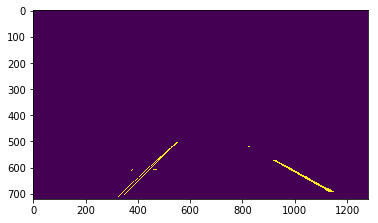

In [4]:
output = 'annotated_project_video.mp4'
clip2 = VideoFileClip('project_video.mp4')
challenge_clip = clip2.fl_image(wrap)
%time challenge_clip.write_videofile(output, audio=False)

appending additional binary masking
[MoviePy] >>>> Building video annotated_challange_video.mp4
[MoviePy] Writing video annotated_challange_video.mp4


  0%|          | 1/485 [00:01<16:02,  1.99s/it]

appending additional binary masking


  2%|▏         | 11/485 [00:18<13:23,  1.70s/it]

appending additional binary masking


  2%|▏         | 12/485 [00:20<13:45,  1.74s/it]

appending additional binary masking


  4%|▎         | 17/485 [00:29<13:24,  1.72s/it]

appending additional binary masking


  4%|▍         | 19/485 [00:33<14:41,  1.89s/it]

appending additional binary masking


  6%|▌         | 27/485 [00:47<12:45,  1.67s/it]

appending additional binary masking


  8%|▊         | 37/485 [01:05<12:10,  1.63s/it]

appending additional binary masking


  8%|▊         | 38/485 [01:07<11:56,  1.60s/it]

appending additional binary masking


  8%|▊         | 39/485 [01:08<11:50,  1.59s/it]

appending additional binary masking


  9%|▊         | 42/485 [01:13<12:18,  1.67s/it]

appending additional binary masking


 15%|█▍        | 72/485 [02:04<12:42,  1.85s/it]

appending additional binary masking


 15%|█▌        | 73/485 [02:06<12:33,  1.83s/it]

appending additional binary masking


 15%|█▌        | 74/485 [02:08<12:20,  1.80s/it]

appending additional binary masking


 16%|█▌        | 76/485 [02:11<11:44,  1.72s/it]

appending additional binary masking


 16%|█▌        | 77/485 [02:13<11:25,  1.68s/it]

appending additional binary masking


 18%|█▊        | 85/485 [02:26<12:18,  1.85s/it]

appending additional binary masking


 18%|█▊        | 87/485 [02:31<14:18,  2.16s/it]

appending additional binary masking


 18%|█▊        | 89/485 [02:35<13:18,  2.02s/it]

appending additional binary masking


 19%|█▊        | 90/485 [02:37<12:37,  1.92s/it]

appending additional binary masking


 19%|█▉        | 92/485 [02:40<11:44,  1.79s/it]

appending additional binary masking


 19%|█▉        | 93/485 [02:42<11:22,  1.74s/it]

appending additional binary masking


 27%|██▋       | 131/485 [03:42<09:59,  1.69s/it]

appending additional binary masking


 27%|██▋       | 133/485 [03:47<12:34,  2.14s/it]

appending additional binary masking


 28%|██▊       | 134/485 [03:49<11:26,  1.95s/it]

appending additional binary masking


 28%|██▊       | 135/485 [03:50<10:39,  1.83s/it]

appending additional binary masking


 28%|██▊       | 136/485 [03:52<10:10,  1.75s/it]

appending additional binary masking


 28%|██▊       | 137/485 [03:54<09:49,  1.69s/it]

appending additional binary masking


 28%|██▊       | 138/485 [03:55<09:27,  1.64s/it]

appending additional binary masking


 29%|██▊       | 139/485 [03:57<09:21,  1.62s/it]

appending additional binary masking


 29%|██▉       | 140/485 [03:59<10:15,  1.78s/it]

appending additional binary masking


 29%|██▉       | 141/485 [04:00<09:52,  1.72s/it]

appending additional binary masking


 29%|██▉       | 142/485 [04:02<09:35,  1.68s/it]

appending additional binary masking


 43%|████▎     | 208/485 [05:56<08:27,  1.83s/it]

appending additional binary masking


 45%|████▍     | 216/485 [06:08<07:05,  1.58s/it]

appending additional binary masking


 45%|████▍     | 217/485 [06:10<07:03,  1.58s/it]

appending additional binary masking


 45%|████▍     | 218/485 [06:12<07:06,  1.60s/it]

appending additional binary masking


 45%|████▌     | 219/485 [06:13<07:10,  1.62s/it]

appending additional binary masking


 45%|████▌     | 220/485 [06:15<07:10,  1.62s/it]

appending additional binary masking
appending additional binary masking


 46%|████▌     | 222/485 [06:19<07:52,  1.80s/it]

appending additional binary masking


 46%|████▌     | 223/485 [06:21<07:55,  1.82s/it]

appending additional binary masking


 46%|████▌     | 224/485 [06:23<08:08,  1.87s/it]

appending additional binary masking


 46%|████▋     | 225/485 [06:25<08:00,  1.85s/it]

appending additional binary masking


 47%|████▋     | 226/485 [06:26<07:46,  1.80s/it]

appending additional binary masking


 47%|████▋     | 227/485 [06:28<07:49,  1.82s/it]

appending additional binary masking


 47%|████▋     | 230/485 [06:34<08:07,  1.91s/it]

appending additional binary masking


 48%|████▊     | 231/485 [06:36<07:57,  1.88s/it]

appending additional binary masking


 48%|████▊     | 232/485 [06:38<07:41,  1.83s/it]

appending additional binary masking


 49%|████▉     | 237/485 [06:46<06:53,  1.67s/it]

appending additional binary masking


 49%|████▉     | 239/485 [06:49<06:52,  1.68s/it]

appending additional binary masking


 50%|█████     | 243/485 [06:56<06:48,  1.69s/it]

appending additional binary masking


 50%|█████     | 244/485 [06:58<06:45,  1.68s/it]

appending additional binary masking


 51%|█████     | 245/485 [06:59<06:46,  1.69s/it]

appending additional binary masking


 51%|█████     | 246/485 [07:01<06:42,  1.68s/it]

appending additional binary masking


 51%|█████     | 247/485 [07:03<06:39,  1.68s/it]

appending additional binary masking


 51%|█████     | 248/485 [07:04<06:38,  1.68s/it]

appending additional binary masking


 51%|█████▏    | 249/485 [07:06<06:36,  1.68s/it]

appending additional binary masking


 52%|█████▏    | 250/485 [07:08<06:31,  1.67s/it]

appending additional binary masking


 52%|█████▏    | 251/485 [07:09<06:30,  1.67s/it]

appending additional binary masking


 61%|██████▏   | 298/485 [08:29<04:44,  1.52s/it]

appending additional binary masking


 62%|██████▏   | 299/485 [08:30<04:43,  1.52s/it]

appending additional binary masking


 62%|██████▏   | 300/485 [08:32<04:44,  1.54s/it]

appending additional binary masking


 62%|██████▏   | 301/485 [08:33<04:42,  1.53s/it]

appending additional binary masking


 62%|██████▏   | 302/485 [08:35<04:41,  1.54s/it]

appending additional binary masking


 62%|██████▏   | 303/485 [08:37<04:38,  1.53s/it]

appending additional binary masking


 63%|██████▎   | 304/485 [08:38<04:36,  1.53s/it]

appending additional binary masking


 63%|██████▎   | 305/485 [08:40<04:37,  1.54s/it]

appending additional binary masking


 63%|██████▎   | 307/485 [08:43<04:32,  1.53s/it]

appending additional binary masking


 65%|██████▍   | 314/485 [08:53<04:18,  1.51s/it]

appending additional binary masking


 65%|██████▍   | 315/485 [08:55<04:17,  1.52s/it]

appending additional binary masking


 65%|██████▌   | 316/485 [08:56<04:17,  1.52s/it]

appending additional binary masking


 65%|██████▌   | 317/485 [08:58<04:15,  1.52s/it]

appending additional binary masking


 66%|██████▌   | 318/485 [08:59<04:13,  1.52s/it]

appending additional binary masking


 66%|██████▌   | 319/485 [09:01<04:15,  1.54s/it]

appending additional binary masking


 67%|██████▋   | 326/485 [09:11<04:03,  1.53s/it]

appending additional binary masking


 67%|██████▋   | 327/485 [09:13<04:00,  1.52s/it]

appending additional binary masking


 68%|██████▊   | 331/485 [09:19<03:53,  1.51s/it]

appending additional binary masking


 68%|██████▊   | 332/485 [09:20<03:52,  1.52s/it]

appending additional binary masking


 69%|██████▊   | 333/485 [09:22<03:55,  1.55s/it]

appending additional binary masking


 69%|██████▉   | 334/485 [09:24<03:55,  1.56s/it]

appending additional binary masking


 71%|███████   | 343/485 [09:38<03:47,  1.60s/it]

appending additional binary masking


 71%|███████   | 344/485 [09:40<03:44,  1.59s/it]

appending additional binary masking


 71%|███████   | 345/485 [09:41<03:44,  1.60s/it]

appending additional binary masking


 71%|███████▏  | 346/485 [09:43<03:44,  1.62s/it]

appending additional binary masking


 73%|███████▎  | 354/485 [09:56<03:32,  1.62s/it]

appending additional binary masking


 73%|███████▎  | 355/485 [09:57<03:27,  1.60s/it]

appending additional binary masking


 73%|███████▎  | 356/485 [09:59<03:27,  1.61s/it]

appending additional binary masking


 74%|███████▎  | 357/485 [10:00<03:23,  1.59s/it]

appending additional binary masking


 74%|███████▍  | 358/485 [10:02<03:20,  1.58s/it]

appending additional binary masking


 74%|███████▍  | 359/485 [10:03<03:17,  1.57s/it]

appending additional binary masking


 74%|███████▍  | 360/485 [10:05<03:16,  1.57s/it]

appending additional binary masking


 74%|███████▍  | 361/485 [10:06<03:12,  1.56s/it]

appending additional binary masking


 76%|███████▌  | 367/485 [10:16<03:05,  1.57s/it]

appending additional binary masking


 76%|███████▌  | 369/485 [10:19<03:10,  1.64s/it]

appending additional binary masking


 76%|███████▋  | 370/485 [10:21<03:18,  1.72s/it]

appending additional binary masking


 76%|███████▋  | 371/485 [10:23<03:23,  1.79s/it]

appending additional binary masking
appending additional binary masking


 77%|███████▋  | 373/485 [10:27<03:24,  1.82s/it]

appending additional binary masking


 79%|███████▊  | 381/485 [10:39<02:42,  1.56s/it]

appending additional binary masking


 79%|███████▉  | 382/485 [10:41<02:41,  1.57s/it]

appending additional binary masking


 79%|███████▉  | 385/485 [10:45<02:34,  1.55s/it]

appending additional binary masking


 89%|████████▊ | 430/485 [12:06<01:33,  1.69s/it]

appending additional binary masking


 89%|████████▉ | 431/485 [12:07<01:31,  1.69s/it]

appending additional binary masking


 90%|████████▉ | 435/485 [12:15<01:40,  2.01s/it]

appending additional binary masking


 90%|█████████ | 437/485 [12:20<01:47,  2.23s/it]

appending additional binary masking


 90%|█████████ | 438/485 [12:22<01:39,  2.11s/it]

appending additional binary masking


 91%|█████████ | 440/485 [12:26<01:26,  1.92s/it]

appending additional binary masking


 91%|█████████ | 441/485 [12:28<01:28,  2.01s/it]

appending additional binary masking


 91%|█████████ | 442/485 [12:30<01:25,  1.98s/it]

appending additional binary masking


 91%|█████████▏| 443/485 [12:32<01:29,  2.12s/it]

appending additional binary masking


 92%|█████████▏| 444/485 [12:34<01:26,  2.12s/it]

appending additional binary masking


 92%|█████████▏| 446/485 [12:38<01:19,  2.04s/it]

appending additional binary masking


 93%|█████████▎| 451/485 [12:47<01:03,  1.85s/it]

appending additional binary masking


 93%|█████████▎| 452/485 [12:50<01:03,  1.94s/it]

appending additional binary masking


 94%|█████████▍| 455/485 [12:55<00:52,  1.74s/it]

appending additional binary masking


 94%|█████████▍| 456/485 [12:56<00:50,  1.73s/it]

appending additional binary masking


 94%|█████████▍| 457/485 [12:58<00:48,  1.72s/it]

appending additional binary masking


 94%|█████████▍| 458/485 [13:00<00:48,  1.78s/it]

appending additional binary masking


 95%|█████████▍| 459/485 [13:02<00:47,  1.81s/it]

appending additional binary masking


 95%|█████████▍| 460/485 [13:03<00:43,  1.76s/it]

appending additional binary masking


 99%|█████████▊| 478/485 [13:32<00:11,  1.67s/it]

appending additional binary masking


 99%|█████████▉| 479/485 [13:34<00:10,  1.67s/it]

appending additional binary masking


 99%|█████████▉| 480/485 [13:35<00:08,  1.63s/it]

appending additional binary masking


 99%|█████████▉| 481/485 [13:37<00:06,  1.66s/it]

appending additional binary masking


 99%|█████████▉| 482/485 [13:39<00:05,  1.71s/it]

appending additional binary masking


100%|█████████▉| 483/485 [13:41<00:03,  1.70s/it]

appending additional binary masking


100%|█████████▉| 484/485 [13:42<00:01,  1.71s/it]

appending additional binary masking


100%|██████████| 485/485 [13:44<00:00,  1.71s/it]

appending additional binary masking


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated_challange_video.mp4 

CPU times: user 13min 46s, sys: 2.6 s, total: 13min 48s
Wall time: 13min 46s


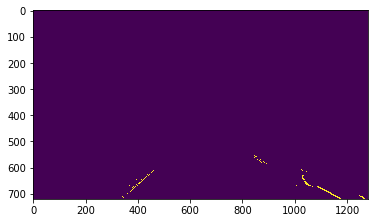

In [5]:
# Challange Video
transformer = setup_transformation_pipeline()
cleft, cright = Line(), Line()
fn = lambda x: process(x, transformer, cleft, cright)

def wrap(image):
    try:
        return fn(image)
    except:
        return image
    
challenge_output = 'annotated_challange_video.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(wrap)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
# Challange Video
transformer = setup_transformation_pipeline()
hcleft, hcright = Line(), Line()
fn = lambda x: process(x, transformer, hcleft, hcright)

def wrap(image):
    try:
        return fn(image)
    except:
        return image
    
challenge_output = 'annotated_harder_challange_video.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
challenge_clip = clip2.fl_image(wrap)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video annotated_harder_challange_video.mp4
[MoviePy] Writing video annotated_harder_challange_video.mp4


 49%|████▉     | 590/1200 [16:46<15:21,  1.51s/it]

appending additional binary masking


 50%|█████     | 601/1200 [17:03<15:14,  1.53s/it]

appending additional binary masking


 50%|█████     | 602/1200 [17:05<15:14,  1.53s/it]

appending additional binary masking


 50%|█████     | 603/1200 [17:06<15:13,  1.53s/it]

appending additional binary masking


 50%|█████     | 604/1200 [17:08<15:22,  1.55s/it]

appending additional binary masking


 50%|█████     | 606/1200 [17:11<15:16,  1.54s/it]

appending additional binary masking


 51%|█████     | 607/1200 [17:12<15:21,  1.55s/it]

appending additional binary masking


 51%|█████     | 608/1200 [17:14<15:21,  1.56s/it]

appending additional binary masking


 51%|█████     | 609/1200 [17:16<15:21,  1.56s/it]

appending additional binary masking


 51%|█████     | 610/1200 [17:17<15:21,  1.56s/it]

appending additional binary masking


 51%|█████     | 611/1200 [17:19<15:23,  1.57s/it]

appending additional binary masking
appending additional binary masking


 51%|█████     | 613/1200 [17:22<15:29,  1.58s/it]

appending additional binary masking


 51%|█████     | 614/1200 [17:23<15:23,  1.58s/it]

appending additional binary masking


 51%|█████▏    | 615/1200 [17:25<15:20,  1.57s/it]

appending additional binary masking


 51%|█████▏    | 616/1200 [17:27<15:20,  1.58s/it]

appending additional binary masking


 51%|█████▏    | 617/1200 [17:28<15:14,  1.57s/it]

appending additional binary masking


 52%|█████▏    | 618/1200 [17:30<15:16,  1.58s/it]

appending additional binary masking


 52%|█████▏    | 619/1200 [17:31<15:08,  1.56s/it]

appending additional binary masking


 52%|█████▏    | 620/1200 [17:33<15:08,  1.57s/it]

appending additional binary masking


 52%|█████▏    | 621/1200 [17:34<15:02,  1.56s/it]

appending additional binary masking


 52%|█████▏    | 622/1200 [17:36<15:10,  1.57s/it]

appending additional binary masking


 52%|█████▏    | 623/1200 [17:38<15:05,  1.57s/it]

appending additional binary masking
appending additional binary masking


 52%|█████▏    | 625/1200 [17:41<15:43,  1.64s/it]

appending additional binary masking


 52%|█████▏    | 626/1200 [17:43<15:25,  1.61s/it]

appending additional binary masking


 52%|█████▏    | 627/1200 [17:44<15:14,  1.60s/it]

appending additional binary masking


 52%|█████▏    | 628/1200 [17:46<15:15,  1.60s/it]

appending additional binary masking


 52%|█████▏    | 629/1200 [17:47<15:05,  1.59s/it]

appending additional binary masking


 52%|█████▎    | 630/1200 [17:49<15:08,  1.59s/it]

appending additional binary masking


 53%|█████▎    | 631/1200 [17:50<15:04,  1.59s/it]

appending additional binary masking


 53%|█████▎    | 632/1200 [17:52<14:59,  1.58s/it]

appending additional binary masking


 53%|█████▎    | 633/1200 [17:54<15:00,  1.59s/it]

appending additional binary masking


 53%|█████▎    | 634/1200 [17:55<15:04,  1.60s/it]

appending additional binary masking


 53%|█████▎    | 635/1200 [17:57<15:05,  1.60s/it]

appending additional binary masking


 53%|█████▎    | 636/1200 [17:58<15:02,  1.60s/it]

appending additional binary masking


 53%|█████▎    | 637/1200 [18:00<14:54,  1.59s/it]

appending additional binary masking


 59%|█████▉    | 705/1200 [19:48<13:06,  1.59s/it]

appending additional binary masking


 59%|█████▉    | 710/1200 [19:56<13:16,  1.62s/it]

appending additional binary masking


 59%|█████▉    | 711/1200 [19:57<13:11,  1.62s/it]

appending additional binary masking


 59%|█████▉    | 712/1200 [19:59<13:01,  1.60s/it]

appending additional binary masking


 59%|█████▉    | 713/1200 [20:01<12:59,  1.60s/it]

appending additional binary masking


 60%|█████▉    | 714/1200 [20:02<12:50,  1.59s/it]

appending additional binary masking
appending additional binary masking


 60%|█████▉    | 716/1200 [20:09<20:44,  2.57s/it]

appending additional binary masking


 60%|█████▉    | 717/1200 [20:10<18:31,  2.30s/it]

appending additional binary masking
appending additional binary masking


 60%|█████▉    | 719/1200 [20:14<17:11,  2.14s/it]

appending additional binary masking


 60%|██████    | 720/1200 [20:16<16:38,  2.08s/it]

appending additional binary masking


 66%|██████▌   | 792/1200 [22:17<10:39,  1.57s/it]